In [1]:
import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from skbio.diversity import alpha_diversity
import networkx as nx
%matplotlib inline

ImportError: cannot import name 'alpha_diversity' from 'skbio.diversity' (unknown location)

In [2]:
names=["Dr_Lowry","Lamya'a","Lauren","Lyanna","John","Flux","Caelan"]

genuses=['Lactobacillus',
       'Bifidobacterium',
       'Feacalibacterium',
       'Akkermansia',
       'Helicobacter',
       'Escherichia',
       'Salmonella']

np.random.seed(seed=42)
data = np.random.randint(10, size=(len(names),7))



#Give the L group more "good" bacteria, less "bad" bacteria
data[:4,:4] += 4
data[:4,4:] -=2
#Give the L group more bacteria in general
data[:4] +=4

#Give the No L group more "bad" bacteria
data[4:,4:] += 8


#zero inflating to make this more fun
is_zero = np.random.randint(2,size=(len(names),7))
data = data*is_zero

In [4]:
df = pd.DataFrame(data,
                  index=names, 
                  columns=genuses)
df['Starts_with_L'] = ['Y','Y','Y','Y','N','N','N']

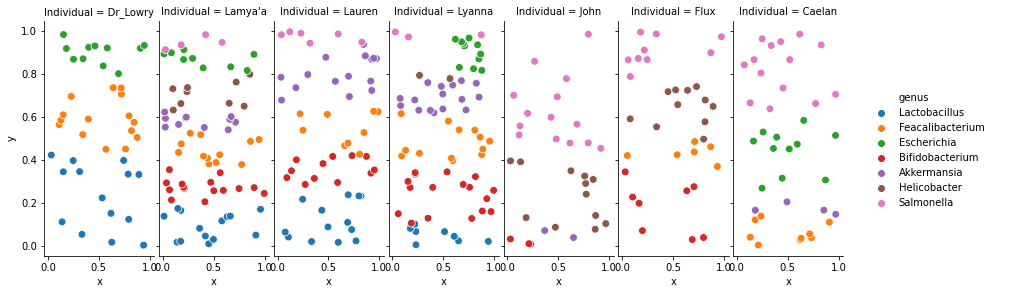

In [7]:
full_df = pd.DataFrame()
for i, row in enumerate(df.index):
    sub_df = pd.DataFrame()
    total = sum(df.drop("Starts_with_L",axis=1).loc[row])
    sub_df["x"] = np.random.uniform(size=total)
    sub_df["y"] = np.sort(np.random.uniform(size=total))
    
    sub_genuses = []
    for col in df.drop("Starts_with_L",axis=1).columns:
        sub_genuses.extend([col for i in range(df.loc[row,col])])
        
    sub_df["genus"] = sub_genuses
    
    
    sub_df["Individual"] = [row]*total
    
    full_df = pd.concat([full_df, sub_df])
    


g = sns.relplot(x="x", y="y", 
                hue="genus", col="Individual",
                data=full_df, 
                s=60)
leg = g._legend

leg.set_bbox_to_anchor([1.15, 0.5])
plt.gcf().set_size_inches(12,4)

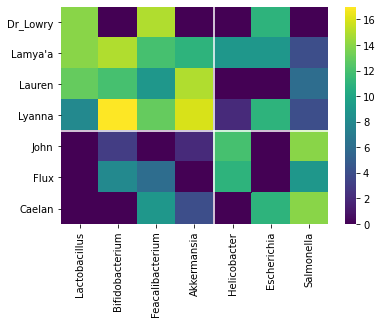

In [23]:
ax = sns.heatmap(df.loc[:,genuses], cmap='viridis')

ax.axhline(4,c='white')
ax.axvline(4,c='white')

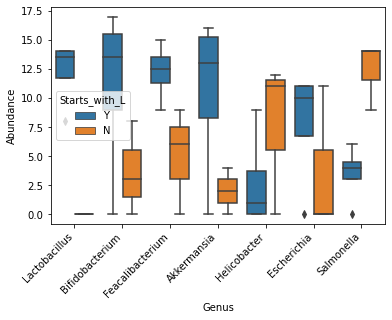

In [25]:
ax = sns.boxplot(x='variable',
                 y='value',
                 hue='Starts_with_L',
                 data=pd.melt(df,
                              ['Starts_with_L']))

ax.set_xticklabels(labels=genuses,
                   rotation=45,
                   ha='right')
ax.set_xlabel("Genus")
ax.set_ylabel("Abundance")
plt.show()

In [26]:
df['observed_otus'] = alpha_diversity('observed_otus', data, ids=df.index)
df['shannon'] = alpha_diversity(metric='shannon', counts=data, ids=df.index)
df['evenness'] = alpha_diversity(metric='pielou_e', counts=data, ids=df.index)

(0.0, 1.2)

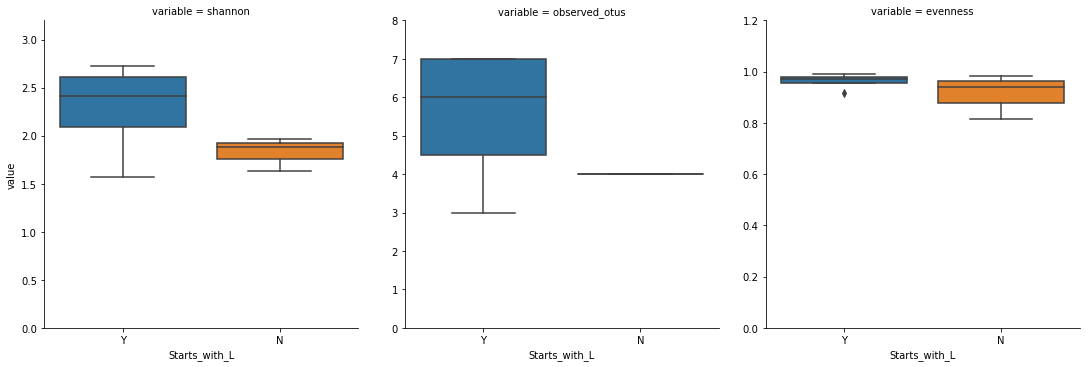

In [27]:
alpha_melted = pd.melt(df[['shannon', 'observed_otus', 'evenness','Starts_with_L']],
                       ['Starts_with_L'])
p = sns.catplot(x='Starts_with_L',
                y='value',
                data=alpha_melted,
                col='variable',sharey=False,kind='box')
p.set(ylim=(0,None))

p.axes[0,0].set_ylim(0,3.2)
p.axes[0,1].set_ylim(0,8)
p.axes[0,2].set_ylim(0,1.2)


# Beta Diversity

# Networks!

In [9]:
tax_corr = df.loc[:,'Lactobacillus':'Salmonella'].corr()

links = tax_corr.stack().reset_index()
links.columns = ['var1', 'var2','value']

links_filtered=links.loc[ (links['value'] > 0.33) & (links['var1'] != links['var2']) ]
links_filtered.head()

,var1,var2,value
1,Lactobacillus,Bifidobacterium,0.403023
2,Lactobacillus,Feacalibacterium,0.732098
3,Lactobacillus,Akkermansia,0.490644
7,Bifidobacterium,Lactobacillus,0.403023
10,Bifidobacterium,Akkermansia,0.831042


In [10]:
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

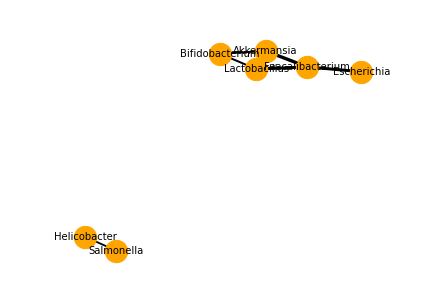

In [11]:
# Plot the network:
nx.draw(G, 
             with_labels=True, 
             node_color='orange', node_size=500, 
             edge_color='black', width=(links_filtered['value']+1)**2, font_size=10)
ax = plt.gca()

ax.set_ylim(ax.get_ylim()[0]-0.25,ax.get_ylim()[1]+0.25)
ax.set_xlim(ax.get_xlim()[0]-0.25,ax.get_xlim()[1]+0.25)

plt.show()

https://awbrooks19.github.io/vmi_microbiome_bootcamp/rst/4_concepts_of_community_analysis.html